In [40]:
import os
import sys
import cv2
import numba
import timeit
import numpy as np
import pandas as pd

from imageio import imread, imwrite
from scipy.ndimage.filters import convolve
from skimage import filters, color
from IPython.display import Image, display
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt

# tqdm is not strictly necessary, but it gives us a pretty progress bar
# to visualize progress.
from tqdm import trange

## Helper method

In [3]:
def display_image(image, fmt='.jpg'):
    _, ret = cv2.imencode(fmt, image) 
    display(Image(data=ret))

## Calculate Seam Energies

This specific energy algorithm assigns higher energies to edges and pixels with higher intensity differences compared to surrounding pixels. When such high intensity differences are encountered, it is likely the result of some prominent features within the image, such as the corners of the bench illustrated below.

### Algorithmic Complexity
#### Time
$O(width * height)$

#### Space
* __Energy:__ $O(width * height)$
* __Cumulative:__ $O(width * height)$

$O(width * height) + O(width * height)$

In [4]:
@numba.jit
def calculate_energy(img):
    height, width, _ = img.shape
    
    intensities = color.rgb2gray(img)
    energy = np.zeros((height, width))
    cumulative = np.zeros((height, width))
    
    for y in range(1, height):
        for x in range(width):
            up    = (y - 1) % height
            down  = (y + 1) % height
            left  = (x - 1) % width
            right = (x + 1) % width
            
            mUp    = cumulative[up, x]
            mLeft  = cumulative[up, left]
            mRight = cumulative[up, right]
            
            cUp    = np.abs(intensities[y, right] - intensities[y, left])
            cLeft  = np.abs(intensities[up, x]    - intensities[y, left])  + cUp
            cRight = np.abs(intensities[up, x]    - intensities[y, right]) + cUp
            
            cUpLeftRight = np.array([cUp, cLeft, cRight])
            mUpLeftRight = np.array([mUp, mLeft, mRight]) + cUpLeftRight
            
            argMin = np.argmin(mUpLeftRight)
            cumulative[y, x] = mUpLeftRight[argMin]
            energy[y, x] = cUpLeftRight[argMin]

    return energy

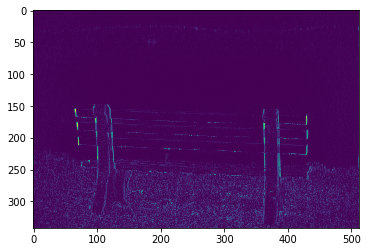

In [5]:
in_filename = 'images/bench3.png'
img = cv2.imread(in_filename)

plt.imshow(calculate_energy(img))


## Tracing Minimum Seams

We now can use the previous algorithm to compute continuous columns that have the least amount of energy. Doing this results in higher energy pixels being kept while lower energy pixels being carved out of the image.

### Algorithmic Complexity
#### Time
$O(width * height)$

#### Space
$O(width * height)$


In [9]:
@numba.jit
def trace_minimum_seams(img):
    height, width, _ = img.shape
    energies = calculate_energy(img)
    backtrack = np.zeros((height, width), dtype=np.int)
    
    for y in range(1, height):
        for x in range(width):
            left  = x - 1 if x != 0 else x
            right = x + 2 # plus two because of indexing
            
            lowest_x = np.argmin(energies[y - 1, left : right])
            lowest_x += left # from relative to absolute position

            backtrack[y, x] = lowest_x
            energies[y, x] += energies[y - 1, lowest_x]

    # The last row will contain the total energy for the entire seam
    return energies, backtrack

## Carve out the Column

After tracing the minimum seams, we can now carve out the one with the lowest energy. The first 70 lowest energy seams for the bench image are shown below in the demo section.

### Algorithmic Complexity
#### Time
$O(height)$

#### Space
$O(width * height * 3)$


In [37]:
@numba.jit
def carve_column(img, highlighted_img):
    height, width, _ = img.shape
    energies, backtrack = trace_minimum_seams(img)

    # Create a (height, width) matrix filled with the value True
    # We'll be removing all pixels from the image which
    # have False later
    mask = np.ones((height, width), dtype=np.bool)

    # Find the position of the smallest element in the
    # last row of M. This gives us the lowest energy column
    # since the energies for each pixel are cumulative
    lowest_x = np.argmin(energies[-1])

    for y in reversed(range(height)):
        # Mark the pixels for deletion
        mask[y, lowest_x] = False
        highlighted_img[y, lowest_x] = (255, 0, 255)
        lowest_x = backtrack[y, lowest_x]

    # Since the image has 3 channels, we convert our
    # mask to 3D
    mask = np.stack([mask] * 3, axis=2)

    # Delete all the pixels marked False in the mask,
    # and resize it to the new image dimensions
    img = img[mask].reshape((height, width - 1, 3))

    return img, highlighted_img

## Cropping the N Columns/Rows

Finally, we can run the above `carve_column` algorithm against the image for the number of rows/columns we wish to carve out of the image. To crop the height of an image, we just rotate the image 90° and run the same set of column carving algorithms against it.

### Algorithmic Complexity
#### Time
$n = num\_columns$

* __Total:__ $O(n) * [O(width * height) + O(height * width) + O(height)]$
* __Simplified:__ $O(n * width * height)$

#### Space
* __Image:__ $O(width * height * 3)$
* __Total:__ $2 * O(width * height * 3) + 3 * O(width * height)$


In [33]:
@numba.jit
def crop_columns(img, num_columns):
    height, width, _ = img.shape
    new_width = width - num_columns
    highlighted_img = img.copy()

    for i in trange(width - new_width):
        img, highlighted_img = carve_column(img, highlighted_img)

    return img, highlighted_img

@numba.jit
def crop_rows(img, num_rows):
    img = np.rot90(img, 1, (0, 1))
    img, highlighted_img = crop_columns(img, num_rows)
    img = np.rot90(img, 3, (0, 1))
    highlighted_img = np.rot90(highlighted_img, 3, (0, 1))
    return img, highlighted_img

# Demo 1

Crops the width of the bench image down by 70 pixels and displays the columns which were carved out.

Original image:


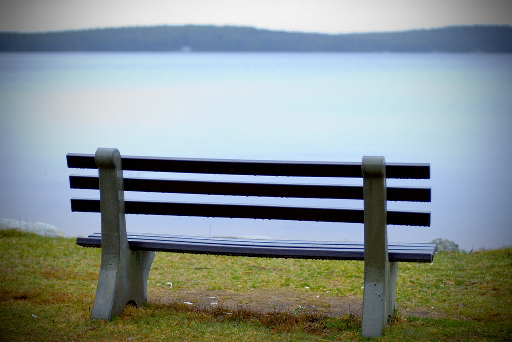

100%|██████████| 70/70 [00:07<00:00, 10.80it/s]

Cropped image:


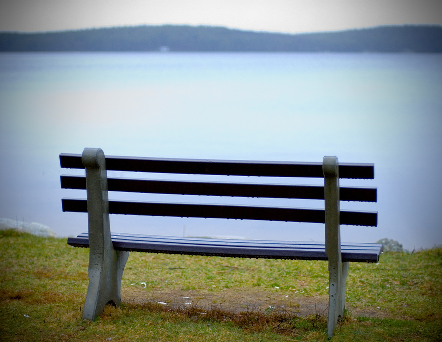

Carved seams:


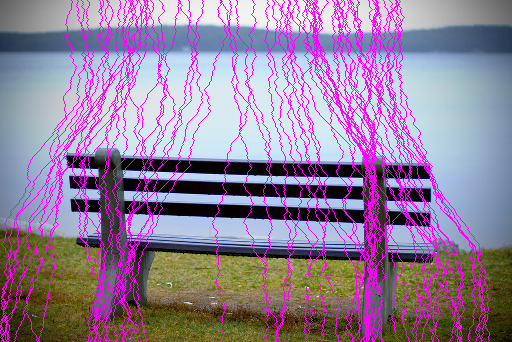

In [35]:
in_filename = 'images/bench3.png'
img = cv2.imread(in_filename)

print("Original image:")
display_image(img, '.png')

# Crop width down by 70 pixels
new_img, highlighted_img = crop_columns(img, 70)

print("Cropped image:")
display_image(new_img, '.png')

print("Carved seams:")
display_image(highlighted_img, '.png')


# Demo 2

Crops the height of the bench image down by 70 pixels and displays the rows which were carved out.

100%|██████████| 70/70 [00:06<00:00, 11.76it/s]

Cropped image:


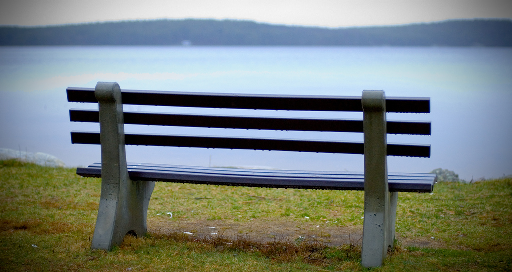

Carved seams:


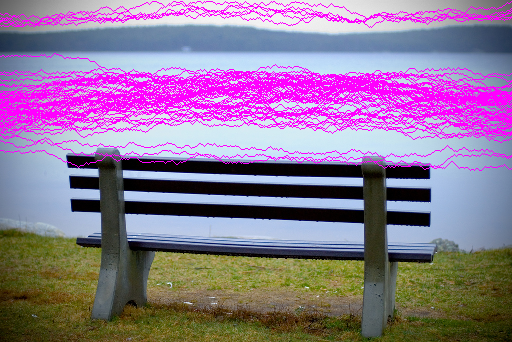

In [36]:
in_filename = 'images/bench3.png'
img = cv2.imread(in_filename)

# Crop height down by 70 pixels
new_img, highlighted_img = crop_rows(img, 70)

print("Cropped image:")
display_image(new_img, '.png')

print("Carved seams:")
display_image(highlighted_img, '.png')


# Benchmarking utils
Borrowed from: https://codereview.stackexchange.com/a/165362/114430

In [31]:
def plot_times(functions, inputs, repeats=3, n_tests=1, file_name=''):
    timings = get_timings(functions, inputs, repeats, n_tests)
    results = aggregate_results(timings)
    fig, ax = plot_results(results)
    
    results.to_csv(file_name)

    return fig, ax, results

def get_timings(functions, inputs, repeats, n_tests):
    for func in functions:
        result = pd.DataFrame(
            index   = inputs,
            columns = range(repeats),
            data    = (timeit.Timer(partial(func, i)).repeat(repeat=repeats, number=n_tests) for i in inputs)
        )
        yield func, result
        
def aggregate_results(timings):
    empty_multiindex = pd.MultiIndex(levels=[[],[]], labels=[[],[]], names=['func', 'params'])
    aggregated_results = pd.DataFrame(columns=empty_multiindex)

    for func, timing in timings:
        for measurement in timing:
            aggregated_results[func.__name__, 'trial ' + str(measurement)] = timing[measurement]
        aggregated_results[func.__name__, 'avg'] = timing.mean(axis=1)
        aggregated_results[func.__name__, 'yerr'] = timing.std(axis=1)

    return aggregated_results

def plot_results(results):
    fig, ax = plt.subplots()
    x = results.index
    for func in results.columns.levels[0]:
        y = results[func, 'avg']
        yerr = results[func, 'yerr']        
        ax.errorbar(x, y, yerr=yerr, fmt='-o', label=func)

    ax.set_xlabel('Input')
    ax.set_ylabel('Time [s]')
    ax.legend()    
    return fig, ax

# Run benchmark

There are three different benchmarks setup:
1. Crop just the width by different amounts
2. Crop just the height by different amounts
3. Crop both the width and height by the same amount



/Users/connor/.local/share/virtualenvs/ContentAwareImageScaling-ML3MrX07/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
100%|██████████| 300/300 [00:19<00:00, 50.52it/s]


(<Figure size 432x288 with 1 Axes>,
 func   test_col_crop                                 test_row_crop             \
 params       trial 0    trial 1        avg      yerr       trial 0    trial 1   
 1           0.150809   0.132185   0.141497  0.013169      0.127874   0.127404   
 10          1.141025   1.177208   1.159116  0.025585      1.077229   1.086624   
 50          5.511855   5.466212   5.489033  0.032274      4.972951   5.014936   
 100        10.891199   9.875608  10.383403  0.718131      9.641518   9.887988   
 200        20.025871  18.751925  19.388898  0.900816     17.120292  16.424097   
 300        24.763709  22.908092  23.835900  1.312119     19.659975  19.693038   
 
 func                        test_both_crop                                  
 params        avg      yerr        trial 0    trial 1        avg      yerr  
 1        0.127639  0.000332       0.260408   0.241866   0.251137  0.013111  
 10       1.081927  0.006643       2.266483   2.318734   2.292608  0.036

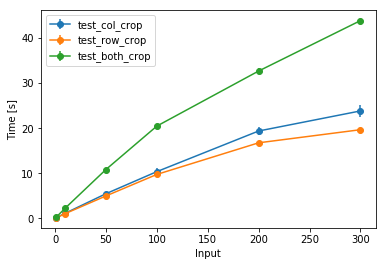

In [47]:
in_filename = 'images/bench3.png'
in_stripped_filename = in_filename.replace('/', '_').replace('.', '_')

os.mkdir('result/' + in_stripped_filename)

img = cv2.imread(in_filename)

def test_col_crop(num_columns):
    new_img, _ = crop_columns(img, num_columns)

    filename = 'result/{}/cropped_width_{}.png'.format(in_stripped_filename, str(num_columns))
    cv2.imwrite(filename, new_img)

def test_row_crop(num_rows):
    new_img, _ = crop_rows(img, num_rows)

    filename = 'result/{}/cropped_height_{}.png'.format(in_stripped_filename, str(num_rows))
    cv2.imwrite(filename, new_img)

def test_both_crop(num):
    # No need to save images here as well since above tests already save them
    new_img, _ = crop_columns(img, num)
    new_img, _ = crop_rows(img, num)

test_params = [1, 10, 50, 100, 200, 300]
plot_times([
    test_col_crop,
    test_row_crop,
    test_both_crop
], test_params, repeats=2, n_tests=1, file_name='result/' + in_stripped_filename + '/crop_tests.csv')


# References

Original method and reference implementation:
* https://jeremykun.com/2013/03/04/seam-carving-for-content-aware-image-scaling/
    * https://github.com/j2kun/seam-carving/blob/master/seam_carving/seam_carving.pde

Reference implementation:
* https://karthikkaranth.me/blog/implementing-seam-carving-with-python/

Improved energy functions:
* https://github.com/axu2/improved-seam-carving/blob/master/Improved%20Seam%20Carving.ipynb
